# Week 6 - Prediction & Causal Inference

Last week, we explored (supervised) text classification, where we train a model to learn associations between text and some classification or value connected with it (e.g., what distinguishes a winning argument before the Supreme Court; can we extend our judgment regarding what documents are relevant to my thesis project to all of Google News; etc.) Classification often uses a representative sample of text about which we want to make inferences and then we use machine learning to learn "true" assignments and classify the rest.

This week, we explore two different types of inferences to out-of-sample populations. _Prediction_ involves our reasoned expectation regarding an unobserved state of the world, given the world in which we live and on which we have trained our prediction algorithm. Often this prediction is about the future world. We don't expect the U.S. Congress to talk about the identical things today and tomorrow, but today should contain some useful information. by contrast _causal inference_ poses the related by distinct challenge of our reasoned expectations regarding an unobserved state of the world IF we intervene in some way. In other words, what does the intervention cause, and how can we predict it to change the world. Causality has a deeply contested history in social science and philosophy, but it usually involves an "if," a difference between two counterfactual worlds, one where an event occurs and one where it doesn't.

Causal questions in text analysis may place the text in one or more of many positions we explore below: as cause, effect, confounder, mediator (or moderator), or collider. For example, assuming that everything spoken can be transcribed into text, saying something mean might hurt someone's feelings (text as cause). Doing something mean might cause someone to say something angry (text as effect). Apologizing might change the influence of doing something mean (text as mediator/moderator). A compliment might obscure the effect of doing something mean (text as confounder). And yelling something audaciously mean might yield a loud, emotional response, which both influence the likelihood that the interaction was recorded and subjected to analysis (text as collider). As you can see, in a single conversation, text can play all of these roles. Why do we care about cause and effect with text? Because while words appear to exert power in the world, which words spoken under what circumstances by whom? Causal analysis attempts to get at the question, if _X_ was written or spoken, _Y_ would happen.

In [ ]:
%%capture
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
!pip install transformers
import lucem_illud #
#All these packages need to be installed from pip
import requests #For getting files
import zipfile #For managing zips
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas as pd #Gives us DataFrames
import numpy as np #Math and matrices
import matplotlib.pyplot as plt #For graphics

# statsmodels is a popular Python statistics package
import statsmodels.api as sm
# Let's also import its graphics module
import statsmodels.graphics.api as smg
# And the mediation module
from statsmodels.stats.mediation import Mediation

# Pipelines to add text-based quantiative variables for regressions
from transformers import pipeline

# We have a lot of features, so let's set Pandas to show all of them.
pd.set_option('display.max_columns', None)

# Prediction
We can make predictions about a range of different text 'populations'. We can use texts in English to predict their translations in French. We can use newspaper articles from 2012 to 2022 to forecast the contents of 2023 newspaper articles (e.g., a [time series](https://en.wikipedia.org/wiki/Time_series)). Or we can "nowcast" by using real-time social information such as Tweets to predict when an important event is happening, such as a riot.

If we don't have any information about how the new population will vary from the population we modeled, then prediction is implemented in the same way as in-sample inference. E.g., if you have a categorization of 2022 emails as spam or ham, you could predict whether 2023 emails are spam the same way you predicted 2022 emails. On the other hand, if you have new information, such as a trend beginning in December 2022 for spam emails to have "Urgent:" in the subject line, your 2023 prediction may differ by putting more weight on that indicator relative to others.

In this way, prediction is similar to the classifications we performed last last week, incorporating multidimensional trends (e.g., time, place, source) learnable from your current corpus. We encourage you to think more about this if you are interested in predicting the future of your corpus!

## <font color="red">*Exercise 1*</font>

<font color="red">Describe 2 separate predictions relevant to your project and associated texts, which involve predicting text that has not been observed based on patterns that have. Then, in a single, short paragraph, describe a research design through which you could use textual features and the tools of classification and regression to evaluate these predictions.

I am interested in whether there's a statistically significant difference in the the length of lyrics and their genres. That is, do the genres of the songs X affect the numbers of words Y in lyrics? Does the gender Z of the artist affect both the length of the songs Y and the genres of the music X?
I think certain genres (like rap music, for example) would have longer lyrics. Additionally, "group" performers might have longer lyrics as well, comparing to singular acts. 

To answer these questions, I perform record linkage to get gender information and group status (collapsed into one column "Gender"). I also extract the genre information from my dataset which comes with a tag columns with lists of all tags associated with the song. I will perform regressio analysis and access the strength and direction of the relationship by looking at relevent statistics like p=value and coefficient, t-statistic and R-squared.

# Text in causal inference

In causal inference, we are interested in the effect of a _treatment_ on an _outcome_. There are five types of variables that could be directly involved in our causal model, and any could be a text variable. This figure from [Keith et al. 2020](https://aclanthology.org/2020.acl-main.474.pdf) concisely shows the five positions for variables in acyclic (i.e., no arrows flow back into themselves) causal inference: treatment, mediator, outcome, confounder, and collider.

<img src="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-6/img/causal_diagram.png" alt="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-6/img/causal_diagram.png" style="width:500px">

"Text as treatment" means the effect of text on other variables. For example, how does the news coverage of a politician affect their election chance? How does the sentiment of a Reddit post affect its upvotes?

Whether we're interested in text as treatment, mediator, outcome, or confounder, we have at our disposal the same causal inference strategies used with other forms of data, such as matching, difference in difference, regression discontinuity, and instrumental variables. Each of these methods usually gives you a more precise conditional identification of the causal influence than regressing an effect on a singular (purported) cause. For example, one of the readings for this week, [Saha 2019](https://doi.org/10.1145/3292522.3326032), uses propensity score matching, which is a straightforward method that works on most datasets (see Professor Gary King on [coarsened exact matching](https://www.youtube.com/watch?v=tvMyjDi4dyg)). For this assignment, we do not detail each of these causal strategies, but note several courses at UChicago that introduce these methods, as well as online textbooks (e.g., Scott Cunningham's [Causal Inference: The Mixtape](https://mixtape.scunning.com/)).

You can do causal inference on any sort of text data as long as you have a plausible _identification_ strategy, meaning an argument that you can correctly identify a causal effect if one exists using your data and analysis. For example, if you have a data from a randomized controlled trial (RCT) where you intervene randomly with some treatment, you can identify a causal effect with relative ease. Text exhibits a wide array of dependencies making unconditional randomization impossible, but we will attempt strategies that approach it. 

# Text as treatment and outcome

To illustrate text as treatment and outcome, we will analyze a dataset of internet arguments. We have 8,895 pairs of comments, where one person makes a statement and the other responds. Our research question is thus: _How does the text of the first commenter affect the text of the respondent?_

The data comes from the [Internet Argument Corpus](https://nlds.soe.ucsc.edu/iac). Let's load the data and take a look.

In [ ]:
url = 'http://nldslab.soe.ucsc.edu/iac/iac_v1.1.zip'

req = requests.get(url)

filename = url.split('/')[-1]
with open(filename,'wb') as output_file:
    output_file.write(req.content)
print('Downloaded file: ' + url)

In [ ]:
with zipfile.ZipFile('iac_v1.1.zip') as z:
   with z.open('iac_v1.1/data/fourforums/annotations/mechanical_turk/qr_averages.csv') as f:
      qr = pd.read_csv(f)

   with z.open('iac_v1.1/data/fourforums/annotations/mechanical_turk/qr_meta.csv') as f:
      md = pd.read_csv(f)

# columns = ['key', 'nicenasty', 'questioning-asserting', 'negotiate-attack', 'fact-feeling']
# qr_sub = qr[columns]
# qr_sub = qr

pairs = qr.merge(md, how='inner', on='key')
pairs = pairs[~pairs.quote_post_id.isnull() & ~pairs.response_post_id.isnull()]
pairs

Note that each comment and response were annotated by workers on Amazon Mechanical Turk, which we piloted last week. Variables like "agree-disagree" are the averages of annotations made by workers on Mechanical Turk on an 11-point Likert scale (-5 to 5) using a slider. Workers were asked questions, and then had the opportunity to note whether or not their were "unsure" about their assessment (Boolean - Y/N):

* __agree/disagree__ (Boolean -- Y/N): Does the respondent agree (0) OR disagree (1) with the prior post?
* __sarcasm__ (Boolean -- Y/N): Is the respondent using sarcasm (1 - Y; 0 - N)?
* __fact/feeling__  (-5 to 5): Is the respondent attempting to make a fact based argument (-5) OR appealing to feelings and emotions (+5)?
* __attack/insult__ (-5 to 5): Is the respondent being supportive/respectful (-5) OR are they attacking/insulting in their writing (+5)?
* __nice/nasty__ (-5 to 5): Is the respondent attempting to be nice (-5) OR is their attitude fairly nasty (+5)?
* __audience__ (-5 to 5): Is the respondent's arguments intended more to be interacting directly with the original poster (-5) OR with a wider audience (+5)?
* __undercutting__ (-5 to 5): Is the argument of the respondent targeted at the entirety of the original poster's argument (-5) OR is the argument of the respondent targed at a more specific idea within the post (+5)?
* __negotiate/attack__ (-5 to 5): Does the respondent seem to have an argument of their own (-5) OR is the respondent simply attacking the original poster's argument (+5)?
* __question/assert__ (-5 to 5): Is the respondent questioning the original poster (-5) OR is the respondent asserting their own ideas (+5)?

Unfortunately the dataset only has the "response" annotated, not the original "quote." However, some "responses" in this dataset are also "quotes," meaning we can form triples of quote-response-response. Let's self-merge this dataframe to get these "r1" and "r2" pairs where both texts have annotations.

In [ ]:
# Self-merge where the 'response' matches another 'quote' in the DataFrame
triples = pairs.merge(pairs,left_on='response',right_on='quote',how='inner',suffixes=('_r1','_r2'))

# Rename and reorder columns
triples = triples.rename(columns={'quote_r1':'quote', 'quote_r2':'response1', 'response_r2':'response2'})
triples = triples.drop(columns=['response_r1'])
front_columns = [
                 'quote','response1','response2','attack_r1','fact-feeling_r1','nicenasty_r1','sarcasm_r1',
                 'agreement_r2'
                ]
triples = triples.dropna(subset=front_columns)
triples = triples[front_columns].join(triples.drop(columns=front_columns))

# Display triples
triples

Now we have 1,346 triples of quote-response1-response2, several text variables of response1 (e.g., "Is the respondent using sarcasm?") that may predict the agreement of response2. In other words: _Does a sarcastic comment lead to more agreement?_ Of course, as with almost all observational data, there are a number of confounders that make our identification difficult, but for now, let's explore how to run a simple regression in Python of agreement_r2 (dependent variable, commonly known as Y) on sarcasm_r1. Fortunately, we do have a strong case for identifying the direction of causality: Because response1 comes before response2, we can rule out the possibility that response2 affects response1.

In [ ]:
# We build an Ordinary Least Squares (OLS) model of agreement_r2 on sarcasm_r1.
# The function sm.add_constant() adds an intercept term to the regression (e.g., b in y = ax + b)
y = triples['agreement_r2']
X_cols = ['sarcasm_r1']
X = sm.add_constant(triples[X_cols])

lm1 = sm.OLS(y,X).fit()
lm1.summary()

The p-value for sarcasm_r1 is 0.855, which means that we fail to reject the null hypothesis that there is no effect of sarcasm on agreement. However, we have other variables that may be confounding the effect of pure "attack" or pure "sarcasm." Let's try adding 3 other annotations to the regression model.

In [ ]:
y = triples['agreement_r2']
X_cols = ['attack_r1','fact-feeling_r1','nicenasty_r1','sarcasm_r1']
X = sm.add_constant(triples[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

The condition number (bottom-right of the output above) is 12.8, indicating high correlations between our predictors or collinearity. This is one of many issues to look out for when running regressions. Let's take a look at the correlations:

In [ ]:
corr_matrix = np.corrcoef(triples[X_cols].T)
smg.plot_corr(corr_matrix, xnames=X_cols)
plt.show()

That's very high correlation between attack_r1 and nicenasty_r1 (recall that nasty is +5...this should be no surprise)! We found a significant effect of attack_r1, but not of nicenasty_r1. If we remove attack_r1 from the model, do you think nicenasty_r1 will be significant?

In [ ]:
y = triples['agreement_r2']
X_cols = ['fact-feeling_r1','nicenasty_r1','sarcasm_r1']
X = sm.add_constant(triples[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

Yes, it is! And the t-value is even larger (i.e., stronger evidence of an effect). With this new regression model, we see a significant effect from attack_r1/nicenasty_r1 and sarcasm_r1, indicating both of these dimensions affect whether the response2 agrees with response1. Note that the coefficients are both positive: For attack_r1/nicenasty_r1, this means that a more "nasty" comment led to more disagreement, and for sarcasm_r1, this means that a more sarcasistic comment led to more disagreement.

For good measure, we can add other variables ourselves, such as sentiment and the character length of the comment. The length may be particularly important based on how it affects the annotations of Mechanical Turk workers. For example, as we were skimming through the data, it seemed like shorter comments were being rated as more nasty. For sentiment, let's use the convenient BERT pipeline we used last week and which we will detail and theorize in weeks to come.

In [ ]:
triples['length_r1'] = triples['response1'].apply(lambda x: len(x))
triples['length_r2'] = triples['response2'].apply(lambda x: len(x))

In [ ]:
sentiment = pipeline("sentiment-analysis")
result = sentiment("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

This version of BERT is built only for texts of up to 512 tokens, so for comments longer than that, we truncate.

In [ ]:
%%time

triples['sentiment_r1'] = triples['response1'].apply(lambda x: sentiment(x[:512])[0]['score'])
triples['sentiment_r2'] = triples['response2'].apply(lambda x: sentiment(x[:512])[0]['score'])

In [ ]:
y = triples['agreement_r2']
X_cols = ['fact-feeling_r1','nicenasty_r1','sarcasm_r1','length_r1','sentiment_r1']
X = sm.add_constant(triples[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

In [ ]:
corr_matrix = np.corrcoef(triples[X_cols].T)
smg.plot_corr(corr_matrix, xnames=X_cols)
plt.show()

The condition number is reasonably high, but our correlatons do not seem too strong. Overall, our finding of significant effects for attack_r1/nasty_r1 and sarcasm_r1 persists with these new controls! This sort of robustness or sensitivity analysis is important for making sure your finding is compelling to yourself and to your audience. Consider doing other robustness checks, such as standardizing these variables before running the regression or adding [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors). (To be clear, the analysis above would likely not be sufficient as proof of a causal effect for a peer-reviewed journal; you would likely need a more conditional approach using matching, instruments or differences in differences.)

## <font color="red">*Exercise 2*</font>

<font color="red">Propose a simple causal model in your data, or a different causal model in the annotated Internet Arguments Corpus (e.g., a different treatment, a different outcome), and test it using a linear or logistic regression model. If you are using social media data for your final project, we encourage you to classify or annotate a sample of that data (either compuationally or with human annotators) and examine the effect of texts on replies to that text (e.g., Reddit posts on Reddit comments, Tweets on Twitter replies, YouTube video transcripts on YouTube comments or ratings). You do not need to make a graph of the causal model, but please make it clear (e.g., "X affects Y, and C affects both X and Y.").
    
<font color="red">Also consider using the [ConvoKit datasets](https://convokit.cornell.edu/documentation/datasets.html)! Anytime there is conversation, there is an opportunity to explore the effects of early parts of the conversation on later parts. We will explore this further in Week 8 on Text Generation and Conversation.
    
<font color="red">***Stretch*** (not required): Propose a more robust identification strategy using either matching, difference in difference, regression discontinuity, or an instrumental variable. Each of these methods usually gives you a more precise identification of the causal effect than a unconditional regression. Scott Cunningham's [Causal Inference: The Mixtape](https://mixtape.scunning.com/) is a free textbook on these topics, and all have good YouTube video explanations.


My model:

Genres --> length of songs


Gender of the aritst affects both genres and length of songs

In [ ]:
data = pd.read_csv("sp_bb_matched.csv", index_col = 0)
data.columns

Index(['artist', 'lyrics', 'year', 'edm', 'latin', 'pop', 'r&b', 'rap', 'rock',
       'Gender', 'year_bin', 'artist_lower', 'gender_matched'],
      dtype='object')

In [ ]:
sentiment = pipeline("sentiment-analysis")
result = sentiment("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

label: NEGATIVE, with score: 0.9991


In [ ]:
data.gender_matched.value_counts()

male                 6775
Unknown              4660
Group                4604
female               1759
non-binary             42
genderfluid            21
androgynous            10
genderqueer             7
transgender woman       5
Name: gender_matched, dtype: int64

In [ ]:
gender = data.loc[data.gender_matched.isin(['male', 'Group', 'female'])]

In [ ]:
gender['sentiment'] = gender['lyrics'].apply(lambda x: sentiment(x[:512])[0]['score'])

RuntimeError: ignored

In [ ]:
gender['lyric_len'] = gender['lyrics'].apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
y = gender['lyric_len']
X_cols = ['edm', 'latin', 'pop', 'r&b', 'rap', 'rock']
for c in X_cols:
    gender[c] = gender[c].astype(int)
X = sm.add_constant(gender[X_cols])

lm = sm.OLS(y,X).fit()
lm.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              lyric_len   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     438.8
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        19:35:33   Log-Likelihood:            -1.1510e+05
No. Observations:               13138   AIC:                         2.302e+05
Df Residuals:                   13131   BIC:                         2.303e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2315.1536     31.050     74.563      0.000    2254.292    2376.016
edm         -718.4191     44.916    -15.995      0.000    -806.460    -630.378
latin       -140.9369     69.922     -2.016      0.044    -277.994      -3.880
pop          111.8019     30.029      3.723      0.000      52.941     170.662
r&b         -280.1578     40.669     -6.889      0.000    -359.876    -200.440
rap         1109.0361     39.594     28.010      0.000    1031.425    1186.647
rock        -901.5800     33.356    -27.029      0.000    -966.962    -836.198
==============================================================================
Omnibus:                    11705.060   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           581343.520
Skew:                           4.136   Prob(JB):                         0.00
Kurtosis:                      34.520   Cond. No.                         6.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that all genres related information have very significant effects on the length of the lyrics! Specifically, rap music and pop music have positive effects on length while edm, latin, pop and rock have negative effects!

In [ ]:
gender = pd.get_dummies(gender, columns = ['gender_matched'])

In [ ]:
gender.columns

Index(['artist', 'lyrics', 'year', 'edm', 'latin', 'pop', 'r&b', 'rap', 'rock',
       'Gender', 'year_bin', 'artist_lower', 'lyric_len',
       'gender_matched_Group', 'gender_matched_female', 'gender_matched_male'],
      dtype='object')

Now let's add gender info into the model.

In [ ]:
y = gender['lyric_len']
X_cols = ['edm', 'latin', 'pop', 'r&b', 'rap', 'rock', 'gender_matched_Group', 'gender_matched_female', 'gender_matched_male']
X = sm.add_constant(gender[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              lyric_len   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     372.6
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        02:38:07   Log-Likelihood:            -1.1496e+05
No. Observations:               13138   AIC:                         2.299e+05
Df Residuals:                   13129   BIC:                         2.300e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    8.8e+13   4.72e+15      0.019      0.985   -9.17e+15    9.34e+15
edm                    -782.2260     44.908    -17.418      0.000    -870.253    -694.199
latin                  -233.0145     69.591     -3.348      0.001    -369.424     -96.605
pop                      58.4431     31.645      1.847      0.065      -3.587     120.473
r&b                    -296.9164     40.773     -7.282      0.000    -376.836    -216.996
rap                    1016.6828     39.558     25.701      0.000     939.143    1094.223
rock                   -890.1464     33.030    -26.950      0.000    -954.890    -825.403
gender_matched_Group    -8.8e+13   4.72e+15     -0.019      0.985   -9.34e+15    9.17e+15
gender_matched_female   -8.8e+13   4.72e+15     -0.019      0.985   -9.34e+15    9.17e+15
gender_matched_male     -8.8e+13   4.72e+15     -0.019      0.985   -9.34e+15    9.17e+15
==============================================================================
Omnibus:                    11675.953   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           582846.975
Skew:                           4.117   Prob(JB):                         0.00
Kurtosis:                      34.574   Cond. No.                     9.42e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.62e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Yes! Even with gender, genre info are still significantly affecting the length. The p-values for gender, however, are not statistically significant. We can even add year of the release of the song

In [ ]:
y = gender['lyric_len']
X_cols = ['edm', 'latin', 'pop', 'r&b', 'rap', 'rock', 'gender_matched_Group', 'gender_matched_female', 'gender_matched_male', 'year']
X = sm.add_constant(gender[X_cols])

lm3 = sm.OLS(y,X).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              lyric_len   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     342.9
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        02:40:33   Log-Likelihood:            -1.1492e+05
No. Observations:               13138   AIC:                         2.299e+05
Df Residuals:                   13128   BIC:                         2.299e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.371e+04   1669.226     -8.212      0.000    -1.7e+04   -1.04e+04
edm                    -824.4013     44.946    -18.342      0.000    -912.502    -736.300
latin                  -233.6276     69.264     -3.373      0.001    -369.395     -97.861
pop                      86.0854     30.827      2.793      0.005      25.661     146.510
r&b                    -261.9145     40.814     -6.417      0.000    -341.916    -181.913
rap                    1040.2469     39.495     26.338      0.000     962.830    1117.664
rock                   -720.5159     37.642    -19.141      0.000    -794.299    -646.733
gender_matched_Group  -4869.2217    555.908     -8.759      0.000   -5958.881   -3779.562
gender_matched_female -4451.7477    557.222     -7.989      0.000   -5543.982   -3359.513
gender_matched_male   -4386.8971    557.502     -7.869      0.000   -5479.681   -3294.113
year                     10.2598      1.107      9.272      0.000       8.091      12.429
==============================================================================
Omnibus:                    11619.751   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           573037.516
Skew:                           4.089   Prob(JB):                         0.00
Kurtosis:                      34.304   Cond. No.                     1.50e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.35e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Turns out that year also affects the length of the song!

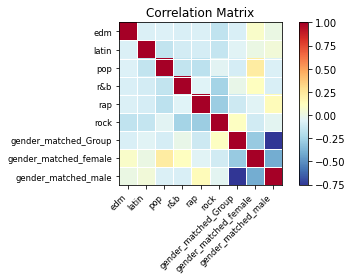

In [ ]:
corr_matrix = np.corrcoef(gender[X_cols].T)
smg.plot_corr(corr_matrix, xnames=X_cols)
plt.show()

## Splitting training and test text
Above, we used a number of external measures of text, meaning that the measures were developed without any influence from this dataset. For annotations, it was Mechanical Turk workers measuring the text. For length, that is a mathematical count of characters. For sentiment, it was from a BERT model not trained on the Internet Arguments Corpus.

This is not always the case. Consider if we want to make a measure of the text based on topic modeling. We build an LDA topic model of these comments, then we select an appealingly relevant topic and measure what number of words from Topic 1 each comment uses. Can we put that measure in the regression? We could, but it would lead to a biased estimate of the true effect size because our measure is no longer external or exogenous. The measure and model are double-dipping from the same textual information. This is important to keep in mind for your final projects, and for a more thorough explanation and justification, you can read more about this in [Egami et al. 2018](https://arxiv.org/pdf/1802.02163.pdf).

One approach to this in the Internet Arguments Corpus would be to build measures with the `pairs` that were not also `triples`. Sometimes we have excess data like this that is similar enough to our regression data, which we can use without reducing our regression sample size. For example, you could abductively generate a keyword-count measure like "argumentativeness" or "thoughtfulness" from non-triple pairs that isn't already in the annotations, and then count the keywords in the triples. You could develop an LDA model or word embedding measurement on some of the data, and the use it to establish an inferential relationship on the rest of the data. This would avoid contamination.

## <font color="red">*Exercise 3*</font>

<font color="red">Propose a measure you could generate to fill in or improve upon the simple causal model you proposed above and how you would split the data (e.g., a % of your main data, a separate-but-informative dataset). You do not have to produce the measure.
    
<font color="red">***Stretch*** (not required): Produce the measure and integrate it into your statistical analysis. This could be a great approach for your final project!

I could use k-fold cross-validation method to validate the results of my regression analysis. K-fold CV splits the training set into k mutually exclusive sets. Each set takes turn to be the validation set and the rest of the folds are used to fit the model. 

# Text as mediator

What if text is instead the _mediator_, meaning it is effected by the teatment and effects the outcome? (A moderator influences the relationship a treatment has on the outcome. This figure from [Bhandari](https://www.scribbr.com/methodology/mediator-vs-moderator/) concisely shows the difference

<img src="https://cdn.scribbr.com/wp-content/uploads/2021/03/mediator-and-moderator-variables.png" alt="https://cdn.scribbr.com/wp-content/uploads/2021/03/mediator-and-moderator-variables.png" style="width:500px">
The moderating impact of a variable can simply be captured by in/excluding the variable alongside the purported cause of interest.)

Let's briefly return to the Internet Arguments Corpus triples and model the effect of the first comment ("quote") on the third comment ("response2") mediated by the second comment ("response1"). Unfortunately we don't have Turker annotations for the first comment, but we can propose a simple mediation model for the propogation of comment length from first to second to third. In other words: _Is there a causal chain of comment length through a conversation?_

A two-step mediation model consists of two linear models, one for each step. Let's create length_q and sentiment_q variables for our model.

In [ ]:
triples['length_q'] = triples['quote'].apply(lambda x: len(x))

In [ ]:
%%time

triples['sentiment_q'] = triples['quote'].apply(lambda x: sentiment(x[:512])[0]['score'])

To run this analysis, statsmodel (sm) has a convenient `Mediation` module that takes in two linear models and outputs a mediation model.

In [ ]:
# Mediation analysis
y = triples['length_r1']
X_cols = ['sentiment_q','length_q']
X = sm.add_constant(triples[X_cols])
mediator_model = sm.OLS(y,X)

# For the second step of the mediation model, we can add in other predictors.
y = triples['length_r2']
X_cols = ['sentiment_q','length_q','fact-feeling_r1','nicenasty_r1','sarcasm_r1','length_r1','sentiment_r1']
X = sm.add_constant(triples[X_cols])
outcome_model = sm.OLS(y,X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='length_q', mediator='length_r1').fit()
med.summary()

It looks like the Average Causal Mediated Effect (ACME) is not significantly different from zero, but the Average Direct Effect (ADE) is. This suggests that the true causal relationship here is more likely:

_length_q -> length_r2_

than

_length_q -> length_r1 -> length_r2_

What do you think explains that relationship?

## <font color="red">*Exercise 4*</font>

<font color="red">Propose a mediation model related to the simple causal model you proposed above (ideally on the dataset you're using for your final project). If you have measures for each variable in the model, run the analysis: You can just copy the "Mediation analysis" cell above and replace with your variables. If you do not have measures, do not run the analysis, but be clear as to the effect(s) you would like to estimate and the research design you would use to test them.

Does Z (year) cause genres difference (Y) which then causes the length of the lyrics (X)?

In [ ]:
# Mediation analysis
y = gender['rap']
X_cols = ['gender_matched_Group', 'gender_matched_female', 'gender_matched_male', 'year']
X = sm.add_constant(gender[X_cols])
mediator_model = sm.OLS(y,X)

# For the second step of the mediation model, we can add in other predictors.
y = gender['lyric_len']
X_cols =  ['edm', 'latin', 'pop', 'r&b', 'rap', 'rock', 'gender_matched_Group', 'gender_matched_female', 'gender_matched_male', 'year']
X = sm.add_constant(gender[X_cols])
outcome_model = sm.OLS(y,X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='year', mediator='rap').fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),2.471621,-7.019779,12.369874,0.656
ACME (treated),2.471621,-7.019779,12.369874,0.656
ADE (control),10.268711,8.236659,12.479387,0.000
ADE (treated),10.268711,8.236659,12.479387,0.000
Total effect,12.740332,3.500594,22.381512,0.006
Prop. mediated (control),0.194565,-1.827581,0.549889,0.650
Prop. mediated (treated),0.194565,-1.827581,0.549889,0.650
ACME (average),2.471621,-7.019779,12.369874,0.656
ADE (average),10.268711,8.236659,12.479387,0.000
Prop. mediated (average),0.194565,-1.827581,0.549889,0.650


We see that thee Average Causal Mediated Effect (ACME) is not significantly different from zero, but the Average Direct Effect (ADE). That suggests the true causal relationship here is more of:

genres -> length of lyrics

rather than

year -> genres -> length of lyrics

# Text as confounder
The causal effect we're interested in estimating might not be our causal relationship of interest. Instead, it could be another variable that affects both our treatment and outcome, known as a _confounder_. Recall the [Keith et al. 2020](https://aclanthology.org/2020.acl-main.474.pdf) figure showing the role of a confounder.

<img src="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-6/img/causal_diagram.png" alt="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-6/img/causal_diagram.png" style="width:500px">

Why do we need to control for confounders? If we didn't, we might correctly find that the treatment and outcome are correlated, but rather than one causing the other, they could both be caused by a third variable. For example, if we are studying the effect of the journal a paper is published in on the citations of the paper, we may be worried that the text of the article affects both whether it is published by the journal and whether people cite it.

The factors we controlled for in the Internet Arguments Corpus could be seen as confounders, but there are also specific methods to control for text confounders. As an example, we will walk through the method proposed by [Pryzant et al. (2018)](https://nlp.stanford.edu/pubs/pryzant2018lexicon.pdf).

Say that we want to know the effect of product descriptions on product popularity. If I'm a shoe seller, how should I describe my shoes to maximize sales? Suppose I have data on sales of other shoes and want to learn from it:

| Description   | Brand   | Sales |
|---------------|---------|-------|
| buy shoes !     | addidas | 15    |
| fresh nike shoes !  | nike    | 35    |
| nice nike shoes ! | nike    | 17    |

It looks like "nike" is associated with higher sales! But that doesn't help me very much because I can't just advertise my shoes as Nikes. That would be incorrect and illegal (false advertising). What if we could build a lexicon of words like "nike" associated with certain brands and control for that in my analysis? We could then identify brand-agnostic words like "fresh" that have the causal effect of interest. This is the approach by Pryzant et al.

Instead of shoes, we're going to work with Consumer Financial Protection Bureau (CFPB) complaints. When US residents complain about financial products (e..g, mortgages, credit reports), the CFPB sometimes handles these on a "timely basis (<15 days)" and sometimes not. If you want to submit a complaint, how should you word it so you get a timely response? We want to control for the differences in wording that result from different products to identify the causal effect of interest. For example, if saying "mortgage" is associated with a timely response, that doesn't mean you should throw "mortgage" into your complaint about a credit report.

Let's download the data and construct a Pandas DataFrame!

In [ ]:
url = 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip'

req = requests.get(url)

filename = url.split('/')[-1]
with open(filename,'wb') as output_file:
    output_file.write(req.content)
print('Downloaded file: ' + url)

Downloaded file: https://files.consumerfinance.gov/ccdb/complaints.csv.zip


In [ ]:
zipfile.ZipFile('complaints.csv.zip').extractall('')

In [ ]:
complaints = pd.read_csv('complaints.csv')
complaints

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-05-03,Student loan,Private student loan,Struggling to repay your loan,Can't get other flexible options for repaying ...,NaN,NaN,Ameritech Financial,FL,33023.0,NaN,Consent not provided,Web,2019-05-15,Untimely response,No,NaN,3231257
1,2021-12-08,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,First Progress Card was notified throughout th...,NaN,Synovus Bank,DE,19805.0,NaN,Consent provided,Web,2021-12-08,Closed with explanation,Yes,NaN,4984749
2,2022-02-02,Checking or savings account,Checking account,Managing an account,Problem accessing account,NaN,NaN,KEYCORP,CA,94539.0,NaN,Other,Web,2022-02-02,In progress,Yes,NaN,5177862
3,2021-12-31,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,"As by Law, under 15 U.S Code 1601- Congression...",Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MD,20744.0,NaN,Consent provided,Web,2021-12-31,Closed with explanation,Yes,NaN,5057575
4,2022-02-08,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MI,48167.0,NaN,NaN,Web,2022-02-08,Closed with explanation,Yes,NaN,5198129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484128,2017-02-09,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt resulted from identity theft,I have disputed my debts several times with no...,NaN,Bonneville Billing and Collections,UT,84054,Servicemember,Consent provided,Web,2017-02-09,Closed with explanation,Yes,No,2334969
2484129,2015-04-29,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,My father died in XX/XX/XXXX. Left me his only...,NaN,"CITIBANK, N.A.",OK,74066,NaN,Consent provided,Web,2015-04-29,Closed with explanation,Yes,No,1352738
2484130,2017-03-31,Credit reporting,NaN,Credit reporting company's investigation,No notice of investigation status/result,cfbp i would Like to file a complaint on Exper...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MN,55379,NaN,Consent provided,Web,2017-03-31,Closed with non-monetary relief,Yes,Yes,2412926
2484131,2017-01-16,Credit reporting,NaN,Incorrect information on credit report,Account status,My husband and I are in the middle of an FHA S...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,30215,NaN,Consent provided,Web,2017-01-16,Closed with explanation,Yes,No,2292586


In [ ]:
complaints['timely'] = complaints['Timely response?'].apply(lambda x: 1 if (x == 'Yes') else 0)

Very interesting! So our goal is to build a lexicon associated with the `Product` column in order to better identify the effect of wording choices in `Consumer complaint narrative` on whether `Timely response?` is `Yes` or `No`. Fortunately Pryzant et al. made a very convenient package to build such a lexicon.

In [16]:
%%capture
!pip install causal-attribution

In [17]:
import causal_attribution

We will use their function called `causal_attribution.score_vocab()`. This takes as input a vocabulary of words that we want to assess, the CSV file with data, and a dictionary that tells the function which column of the CSV is your input, your control, and your intended prediction. What vocabulary should we use? Let's put in some words related to the `Product` column as well as some words that may causally effect `Timely response?`. You can also run it on much larger vocabularies (Pryzant et al. use 2000), but it will take more time to compute.

In [ ]:
product_num = complaints['Product'].value_counts()
product_num

Credit reporting, credit repair services, or other personal consumer reports    966221
Debt collection                                                                 406460
Mortgage                                                                        346977
Credit reporting                                                                140430
Credit card or prepaid card                                                     134782
Checking or savings account                                                     112835
Credit card                                                                      89190
Bank account or service                                                          86206
Student loan                                                                     65047
Money transfer, virtual currency, or money service                               37145
Consumer Loan                                                                    31600
Vehicle loan or lease                      

In [ ]:
%%time

importance_scores = causal_attribution.score_vocab(
    vocab=[
           # Words I expect to be associated with Product
           'credit','loan','bank','card','mortgage','transfer','account','money','virtual','paypay','prepaid','lease',
           # Words I expect to be associated with timeliness
           'fraud','crime','urgent','please','help',
           # Words I expect to not be associated with either
           'bad','good','help','thank','why','husband','wife','family'
          ],
    csv='complaints.csv',
    delimiter=",",
    name_to_type={
        'Consumer complaint narrative': 'input',
        'Product': 'control',
        'Timely response?': 'predict',
    })

importance_scores['Timely response?']['Yes']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()


CPU times: user 32.1 s, sys: 4.08 s, total: 36.2 s
Wall time: 36.4 s


That output isn't that intuitive, but in theory, higher scores correspond to words that better explain `Timely response?` when controlling for `Product`. This suggests that saying `mortgage` is actually a good way to get a timely response even if your complaint isn't about a mortgage! That's interesting. As with other causal inference approaches, we can take a closer look at our data to help explain the results. For example, let's look at whether the `Mortgage` `Product` category had a very high timeliness rate. 

You can ignore 'UNK' and 'PAD', but if you're curious, 'UNK' refers to all tokens that are in the corpus but not in the vocab, and 'PAD' refers to padding added to texts to make their length consistent—-this is common in neural networks because the network is usually designed with a certain input length, so you need to add padding tokens if the input is shorter. You will see padding very frequently in other text-based neural networks and should keep it in mind when building your own in the future.

In [ ]:
product_timelies = complaints.groupby('Product').agg({'timely': 'sum'}).sort_values(by=['timely'],ascending=False)
pcts = product_timelies.divide(product_num,axis=0).sort_values(by=['timely'],ascending=False)
pcts

Mortgage is in the middle of the pack, so it doesn't seem like mortgages in themselves are extremely likely to be responded to in a timely manner. This is something you can explore in more detail if you have time and interest. For example, you can check for which products the word `mortgage` is most strongly associated with timeliness.

## <font color="red">*Exercise 5*</font>

<font color="red">Propose a confounder in your final project data that could be controlled for using the method of Pryzant et al. Generate an appropriate CSV file and run it on some vocabulary in your corpus. If you have no such confounder available for your final project, you can use `complaints.csv` with a new vocabulary or for different variables (e.g., `Sub-product`, `Company`) or you can further explore the interesting case of `mortgage`. Also keep in mind the [ConvoKit datasets](https://convokit.cornell.edu/documentation/datasets.html). In any case, be sure to interpret the results. What does the output of `causal_attribution.score_vocab()` mean in your context?

New causal model: Track lyrics and track popularity have a causal relationship. 
I propose that genre (whether the song is a rap song or not) could be a confounder. 

In [10]:
import pandas as pd
data = pd.read_csv("sp_bb_matched.csv", index_col = 0)
data.columns

Index(['artist', 'lyrics', 'year', 'popularity', 'edm', 'latin', 'pop', 'r&b',
       'rap', 'rock', 'Gender', 'year_bin', 'artist_lower', 'gender_matched'],
      dtype='object')

In [11]:
data = data[(~data.popularity.isna()) & (data.gender_matched != "Unknown")]

In [13]:
data = data.drop(columns = ["artist_lower", "Gender"])

In [18]:
data.to_csv("data.csv")

In [19]:
data.columns

Index(['artist', 'lyrics', 'year', 'popularity', 'edm', 'latin', 'pop', 'r&b',
       'rap', 'rock', 'year_bin', 'gender_matched'],
      dtype='object')

In [21]:
data.sort_values(by ='popularity', ascending = False)

,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,year_bin,gender_matched
5616,Tones and I,"They say, ""Oh my God, I see the way you shine ...",2019,100.0,False,False,True,False,False,False,2010s,female
11573,Arizona Zervas,"All for the 'Gram Bitches love the 'Gram Oh, w...",2019,99.0,False,True,False,False,False,False,2010s,male
4237,Maroon 5,Here's to the ones that we got Cheers to the w...,2019,98.0,False,False,True,False,False,False,2010s,male
3912,Post Malone,"Oh, oh, oh Oh, oh, oh Oh, oh, oh, oh, oh We ...",2019,98.0,False,False,True,False,False,False,2010s,male
1117,Roddy Ricch,Pullin' out the coupe at the lot Told 'em fuck...,2019,98.0,False,False,False,False,True,False,2010s,male
...,...,...,...,...,...,...,...,...,...,...,...,...
7870,Rick Ross,NA Geah Classic hip hop shit Dr. D-R-E Rozay a...,2012,0.0,False,False,False,False,True,False,2010s,male
2960,Supertramp,"NA Ooh, yeah Alright Here we go again Neah nea...",1987,0.0,False,False,False,False,False,True,1980s,male
12848,New Edition,Everybody's saying silly things Without knowin...,2005,0.0,False,False,False,False,False,True,2000s,Group
2982,The Game,"Pull the rag off the six-fo' Hit the switch, s...",2006,0.0,False,False,False,False,True,False,2000s,male


In [22]:
data.loc[5616, 'lyrics']

'They say, "Oh my God, I see the way you shine Take your hands, my dear, and place them both in mine" You know you stopped me dead while I was passing by And now I beg to see you dance just one more time Ooh, I see you, see you, see you every time And oh my, I, I like your style You, you make me, make me, make me wanna cry And now I beg to see you dance just one more time So they say Dance for me, dance for me, dance for me, oh-oh-oh I\'ve never seen anybody do the things you do before They say Move for me, move for me, move for me, ayy-ayy-ayy And when you\'re done, I\'ll make you do it all again I said, "Oh my God, I see you walking by Take my hands, my dear, and look me in my eyes"Just like a monkey, I\'ve been dancin\' my whole life But you just beg to see me dance just one more time Ooh, I see you, see you, see you every time And oh my, I, I like your style You, you make me, make me, make me wanna cry And now I beg to see you dance just one more time So they say Dance for me, danc

In [31]:
%%time

importance_scores = causal_attribution.score_vocab(
    vocab=[
           # Words I expect to be associated with rap
           'bitch','lit','fuck','shit','nigga','shawty','money','money',
           # Words I expect to be associated with popularity
           'love','dear','cry','please','time', 'dance',
           # Words I expect to not be associated with either
           'I','you','help','my','oh','she','he'
          ],
    csv='data.csv',
    delimiter=",",
    name_to_type={
        'lyrics': 'input',
        'rap': 'control',
        'popularity': 'predict',
    })

#importance_scores['Timely response?']['Yes']

CPU times: user 11.9 s, sys: 200 ms, total: 12.1 s
Wall time: 12.1 s


In [32]:
importance_scores['popularity']

defaultdict(list,
            {'N/A': [('UNK', 36.71599233150482),
              ('shawty', 8.95956440269947),
              ('lit', 7.038148015737534),
              ('I', 5.383372563868761),
              ('bitch', 2.68325551180169),
              ('my', 2.136355461552739),
              ('dear', 2.08261786820367),
              ('he', 2.068040550686419),
              ('she', 1.9193234564736485),
              ('fuck', 1.7840789987239987),
              ('dance', 1.762383165769279),
              ('you', 1.5877274442464113),
              ('oh', 1.2381620721425861),
              ('shit', 1.147179220803082),
              ('cry', 0.8378545228624716),
              ('money', 0.6767420503310859),
              ('love', 0.11372515419498086),
              ('money', 0.1038433110807091),
              ('time', -0.15778986271470785),
              ('PAD', -0.22980637222644873),
              ('nigga', -1.4090447233902523),
              ('please', -1.4966486738994718),
              ('hel

Conditioned on whether the music is rap song or not, the words that responded to track popularity are "shawty", "lit", "I" and surperisingly "bitch". There seems to be a positive response from the music fans about the use of this gendered-slur.

In [27]:
rap_num = data['rap'].value_counts()
rap_num

False    8423
True     1515
Name: rap, dtype: int64

In [29]:
rap_pop = data.groupby('rap').agg({'pop': 'sum'}).sort_values(by=['pop'],ascending=False)
pcts = rap_pop.divide(rap_num,axis=0).sort_values(by=['pop'],ascending=False)
pcts

,pop
rap,
False,0.308679
True,0.000000


However, we see that in fact non-rap music are more likely to be rated higher in popularity. This finding is important because rap music always get the bad reputation for being misogynistic. Yet, when other genres (non-rap) use the word "bitch" there're evidently postive response.

# "Causally sufficient" embedding and topic models
Our final example of causal inference with text is from Victor Veitch (now a statistics and CS professor at UChicago), Sridhhar, and Blei. You may recall Blei as the lead developer of LDA, HDP, and Dynamic topic models, among other amazing contributions to content analysis.

Their 2020 paper, ["Adapting Text Embeddings for Causal Inference"](https://arxiv.org/abs/1905.12741), proposes reducing the dimensions of contextual text embeddings (from BERT) in a manner that preserves causally relevant text signals. For example: "Does adding a theorem to a paper affect its chance of acceptance?" We can apply supervised dimensionality reduction to make the embedding easier to analyze (i.e., lower dimension) but preserve information about whether theorems are present. Similar to Pryzant et al., Veitch et al. have a great [GitHub respository](https://github.com/blei-lab/causal-text-embeddings) with the data and code for their paper, and their dataset of computer science papers, PeerRead, has its own great [repo](https://github.com/allenai/PeerRead).

Their code is somewhat too hefty and farflung for this assignment, but for your future research, keep in mind that you can adjust your textual objects (e.g., keyword counts, topic models, word embeddings) for causal models. Bringing together unsupervised machine learning with causal inference is an exciting and rapidly developing field!

## <font color="red">*Exercise 6*</font>

<font color="red">Pick one other paper on causal inference with text from the ["Papers about Causal Inference and Language
" GitHub repository](https://github.com/causaltext/causal-text-papers). Write at least three sentences summarizing the paper and its logic of design in your own words.
    
<font color="red">***Stretch*** (not required): Skim a few more papers. The causal world is your textual oyster!

In the paper *Influence via Ethos: On the Persuasive Power of
Reputation in Deliberation Online*, the authors constructed a measurement for reputation and use the instrument to isolate the causal effects of reputaion on persuasion while controlling for unstructured argument text. They assembled a dataset of over a million debates over 7 years from the ChangeMyView subreddit. The authors are interested in isolating the effects of reputation alone on whether the challengers on Reddit successfully change the posters' veiwpoints.Therefore they need to control for the primiary source of persuasion- the textual responses. They do that though a nonparametric way of "double machine-learning" where they estimate a partially-linear instrumental variable with text as a control learnt through neural networks. 